In [1]:
import sys
sys.path.append('..')

from transformers import Trainer
from transformers import PatchTSTConfig, PatchTSTPreTrainedModel, PatchTSTModel
import torch
from TimeSeriesJEPA.models.PatchTST import PatchTSTModelJEPA, PatchTSTPredictorModelJEPA
from TimeSeriesJEPA.datasets.mask_utils import apply_masks
from torch.utils.data import DataLoader
from TimeSeriesJEPA.datasets.mask_collator import TimeSeriesMaskCollator
from TimeSeriesJEPA.datasets.time_moe_dataset import TimeMoEDataset
from TimeSeriesJEPA.datasets.time_moe_window_dataset import TimeMoEWindowDataset
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F

In [2]:
context_length = 512
prediction_length=0
patch_size=8
stride=8
pred_mask_scale=(0.15, 0.2)
enc_mask_scale=(0.85, 1)
nenc=1
npred=3
allow_overlap=False
min_keep=5
model_file_path = r"D:\Coursework\MTS\timeseriesJEPA\results\PatchTST_Time300B_sl512_enc_dm256_nh16_el4_fd256_pred_dm64_nh4_el2_fd64_bs256_lr0.0001_clean_data\checkpoint-13100"

In [3]:
ds = TimeMoEDataset(r'D:\Time_300B', val=True)
windowds = TimeMoEWindowDataset(ds, context_length=context_length, prediction_length=prediction_length)
mask_collator = TimeSeriesMaskCollator(
            seq_len=context_length,
            patch_size=patch_size,
            stride=stride,
            pred_mask_scale=pred_mask_scale,
            enc_mask_scale=enc_mask_scale,
            nenc=nenc,
            npred=npred,
            allow_overlap=allow_overlap,
            min_keep=min_keep,
            )
data_loader = DataLoader(
        windowds,
        batch_size=1,
        shuffle=True,
        num_workers=0,
        drop_last=True,
        collate_fn=mask_collator
        )

before split:  47
after split:  5


100%|██████████| 23304/23304 [00:00<00:00, 1399883.43it/s]


In [4]:
encoder_model = PatchTSTModelJEPA.from_pretrained(model_file_path)
target_encoder_model = PatchTSTModelJEPA.from_pretrained(os.path.join(model_file_path, "Target_encoder"))
predictor_model = PatchTSTPredictorModelJEPA.from_pretrained(os.path.join(model_file_path, "Predictor"))

In [5]:
def plot_time_series(data, mask=None, p=None,s=None):
   # Convert tensor to numpy array
   data_np = data.squeeze().numpy()
   time = range(len(data_np))
   plt.figure(figsize=(12, 6))
   plt.plot(time, data_np)
   if mask != None:
      mask = mask.squeeze().numpy()
      for i in mask:
         highlight_range = [i*p, (i*p)+p+1]
         plt.plot(time[highlight_range[0]:highlight_range[1]], 
            data_np[highlight_range[0]:highlight_range[1]], 
            color='red')

   plt.title('Time Series Data')
   plt.xlabel('Time Step')
   plt.ylabel('Value')
   plt.grid(True)
   plt.show()

In [6]:
i = 0
t = 5
for seq_x, label, inputmask, collated_masks_enc, collated_masks_pred in data_loader:
    if i == t:
        break
    i+=1
print("enc mask shape: ", collated_masks_enc[0].shape)
print("pred mask shape: ", collated_masks_pred[0].shape)
print("pred mask shape: ", collated_masks_pred[1].shape)
print("pred mask shape: ", collated_masks_pred[2].shape)

enc mask shape:  torch.Size([1, 1, 29])
pred mask shape:  torch.Size([1, 1, 10])
pred mask shape:  torch.Size([1, 1, 10])
pred mask shape:  torch.Size([1, 1, 10])


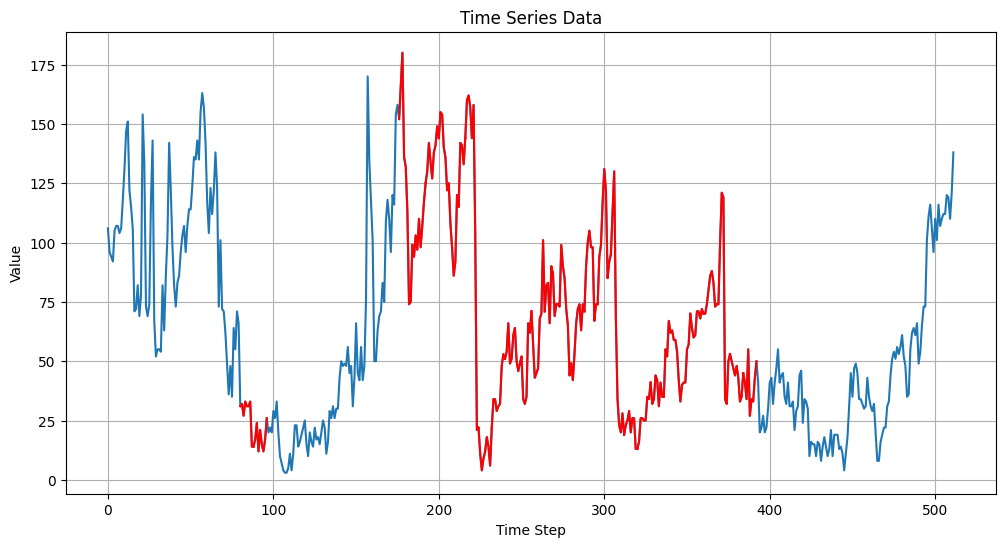

In [7]:
plot_time_series(seq_x, collated_masks_enc[0], p=patch_size)

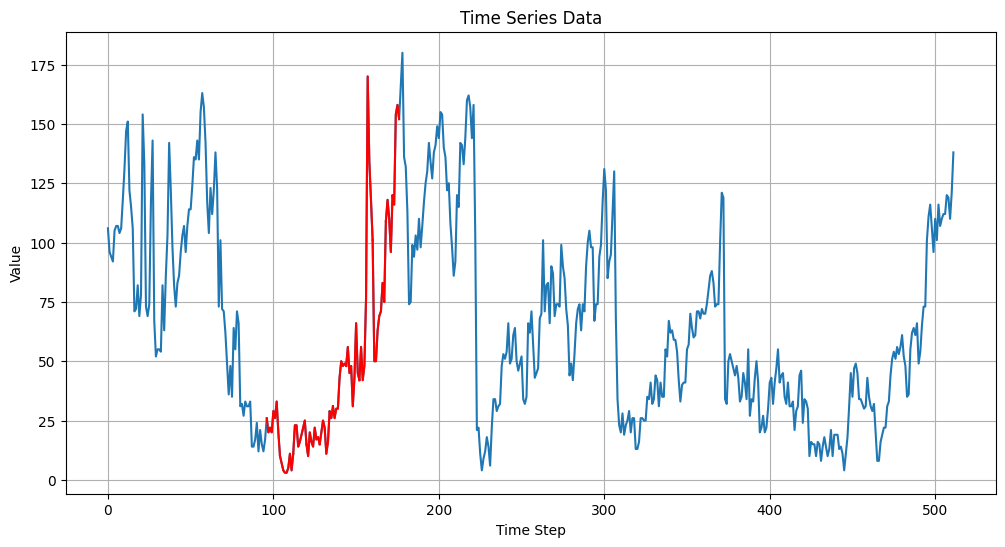

In [8]:
plot_time_series(seq_x, collated_masks_pred[0], p=patch_size)

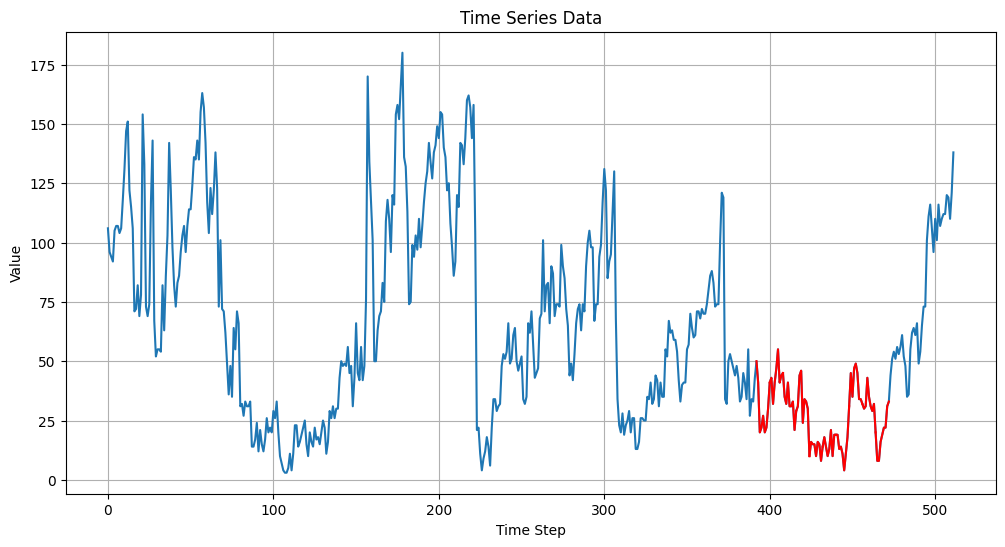

In [9]:
plot_time_series(seq_x, collated_masks_pred[1], p=patch_size)

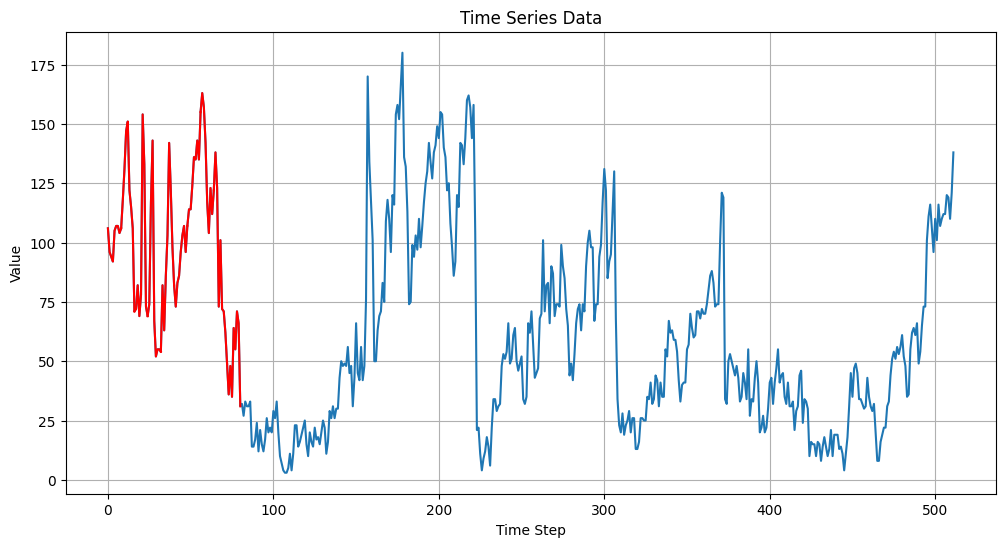

In [10]:
plot_time_series(seq_x, collated_masks_pred[2], p=patch_size)

In [11]:
def forward_context():
    with torch.no_grad():
        encoder_embd = encoder_model(seq_x, collated_masks_enc)
        predictor_embd = predictor_model(encoder_embd[0], collated_masks_enc, collated_masks_pred)
        return encoder_embd[0], predictor_embd[0]

def forward_target():
    with torch.no_grad():
        h = target_encoder_model(seq_x)
        a = F.layer_norm(h[0], (h[0].size(-1),))  # normalize over feature-dim
        B = len(a[0])
        # -- create targets (masked regions of h)
        a = apply_masks(a, collated_masks_pred)
        return h[0], a
def loss_fn(z, h):
    loss = F.l1_loss(z, h)
    return loss

encoder_embd, predictor_embd = forward_context()
full_target_embd, target_embd = forward_target()
loss = loss_fn(predictor_embd, target_embd)

In [12]:
print(loss)

tensor(0.2580)


In [13]:
encoder_embd.shape

torch.Size([1, 1, 29, 256])

In [14]:
predictor_embd.shape

torch.Size([3, 1, 10, 256])

In [15]:
target_embd.shape

torch.Size([3, 1, 10, 256])

In [16]:
print(predictor_embd.norm(dim=3))
print(predictor_embd)

tensor([[[14.4870, 14.4463, 14.3056, 14.1750, 14.1218, 14.0537, 13.9619,
          13.9299, 13.9327, 13.9064]],

        [[14.0468, 13.9883, 14.0178, 14.1205, 14.2648, 14.3548, 14.2918,
          14.1998, 14.1929, 14.1875]],

        [[14.0786, 14.3303, 14.3449, 14.3991, 14.5401, 14.6399, 14.6150,
          14.4635, 14.2799, 14.2229]]])
tensor([[[[-7.5670e-01,  2.1784e-01, -2.7622e-01,  ...,  8.0514e-01,
            4.7500e-01, -5.3110e-01],
          [-4.8430e-01,  2.4789e-01, -2.0237e-01,  ...,  6.9495e-01,
            4.5734e-01, -6.0692e-01],
          [-2.1340e-01,  7.1502e-02, -1.8715e-01,  ...,  5.9758e-01,
            4.3483e-01, -6.3205e-01],
          ...,
          [-1.4635e-01, -1.5549e-01, -6.9678e-01,  ...,  7.6863e-01,
            3.3923e-01,  2.9101e-02],
          [-1.1171e-01, -3.1881e-01, -3.8767e-01,  ...,  1.0459e+00,
            7.5140e-02,  6.8466e-02],
          [-1.8550e-01, -4.9959e-01, -1.0456e-01,  ...,  1.2554e+00,
           -9.6060e-02,  4.9729e-02]]],




In [17]:
print(target_embd.norm(dim=3))
print(target_embd)

tensor([[[15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999,
          15.9999, 15.9999, 15.9999]],

        [[15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999,
          15.9999, 15.9999, 15.9999]],

        [[15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999, 15.9999,
          15.9999, 15.9999, 15.9999]]])
tensor([[[[-0.2327,  0.1986, -0.4694,  ...,  0.2354,  0.5941, -0.1179],
          [ 0.4528,  0.2531,  0.0352,  ...,  0.3808,  0.8425, -0.5851],
          [ 0.4461,  0.0859, -0.2091,  ..., -0.0384,  0.4546, -0.3651],
          ...,
          [-0.9149,  0.3734, -0.4304,  ...,  0.6356,  0.4786, -0.1062],
          [-0.3769, -0.0069, -0.1513,  ...,  1.3127,  0.2031, -0.3131],
          [-0.8356, -0.4857,  0.7502,  ...,  1.1591, -0.6289, -0.3997]]],


        [[[ 0.0964, -0.7790, -0.0992,  ...,  1.6881,  0.4570,  0.1682],
          [ 0.1481, -0.1750, -0.1909,  ...,  1.0257, -0.1817,  0.0669],
          [ 0.8358, -0.4932, -0.6787,  ...,  1.1788,  0.2220,  0.6

In [18]:
print(encoder_embd.norm(dim=3))
print(encoder_embd)

tensor([[[15.6718, 15.6717, 15.6970, 15.6985, 15.6853, 15.6870, 15.6915,
          15.6846, 15.7049, 15.7008, 15.6964, 15.6917, 15.6780, 15.6781,
          15.6808, 15.6726, 15.6772, 15.6780, 15.6611, 15.6817, 15.6825,
          15.6699, 15.6679, 15.6687, 15.6732, 15.6768, 15.6764, 15.6871,
          15.6871]]])
tensor([[[[-0.2523, -0.5052, -0.1355,  ..., -0.0545,  0.7695, -0.0775],
          [ 0.2509, -0.7130, -0.3614,  ..., -0.2476,  0.8487, -0.1111],
          [-0.4566, -0.0662,  0.1672,  ...,  0.7019,  0.0569, -0.1837],
          ...,
          [-0.4330, -0.4151,  0.0227,  ...,  1.5048,  0.4633, -0.5953],
          [-0.0374, -1.6946, -0.8678,  ...,  1.4008,  0.8142,  0.2927],
          [ 0.2246, -1.5260, -0.6429,  ...,  1.2027,  0.9916,  0.1663]]]])


In [19]:
print(full_target_embd.norm(dim=3))
print(full_target_embd)

tensor([[[15.7042, 15.7076, 15.7072, 15.6956, 15.7033, 15.6939, 15.7069,
          15.7061, 15.6882, 15.6773, 15.6723, 15.6770, 15.6789, 15.6864,
          15.6822, 15.6820, 15.6819, 15.6813, 15.6922, 15.7019, 15.7027,
          15.6943, 15.6928, 15.6994, 15.6846, 15.6901, 15.6926, 15.6911,
          15.7066, 15.6967, 15.6981, 15.6894, 15.6823, 15.6867, 15.6905,
          15.6725, 15.6836, 15.6846, 15.6762, 15.6871, 15.6803, 15.6731,
          15.6727, 15.6702, 15.6804, 15.6825, 15.6836, 15.6801, 15.6753,
          15.6745, 15.6700, 15.6715, 15.6690, 15.6848, 15.6843, 15.6869,
          15.6821, 15.6847, 15.6898, 15.6874, 15.6862, 15.6907, 15.6825,
          15.6817]]])
tensor([[[[ 0.2879,  0.3580,  0.4780,  ...,  0.3939, -0.4407, -0.1484],
          [ 0.1384,  0.6359,  1.0791,  ...,  0.5326, -0.5545, -0.6064],
          [ 0.0458,  0.6016,  0.3267,  ...,  0.1414, -0.1324, -0.7548],
          ...,
          [-0.4922, -0.6363,  0.0964,  ...,  1.7410, -0.8011, -0.0424],
          [-0.4252